In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.autograd as autograd
# from torchviz import make_dot
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Seed control, for reproducibility 
seed = 22
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    # work on a single GPU or CPU
    cudnn.benchmark=True
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    Tensor = torch.cuda.FloatTensor
else:
    device = torch.device("cpu")
    cudnn.benchmark=False
    Tensor = torch.FloatTensor

print(device)


cpu


In [95]:
batch_size = 25

dataset = dset.CIFAR10(root='data/cifar/', download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))

# frogs are the sixth class in the dataset 
classes = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
frog = 6
frog_index = [i for i, x in enumerate(dataset.targets) if x == 6]
print("number of frog imgs: ", len(frog_index))

frog_set = torch.utils.data.Subset(dataset, frog_index)


dataloader = torch.utils.data.DataLoader(frog_set, batch_size=batch_size,
                                         shuffle=True, num_workers=1)

Files already downloaded and verified
number of frog imgs:  5000


In [96]:
def imshow(img):
    
    npimg = img.numpy() / 2 + 0.5 # from tensor to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

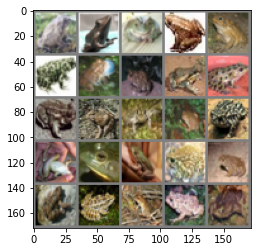

Image shape:  torch.Size([3, 32, 32])


In [97]:
# get some random training images
dataiter = iter(dataloader)
real_image_examples, _ = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(real_image_examples, nrow=5))
print("Image shape: ", images[0].size())


In [57]:
latent_dim = 32
height = 32
width = 32
channels = 3

class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        # First, transform the input into a 16x16 128-channels feature map
        self.init_size = width // 4
        self.l1 = nn.Sequential(
            nn.Linear(latent_dim, 128 * self.init_size ** 2),
        )
        # Since PyTorch has no Reshape layer,
        # we do the reshape in the forward function

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),

            # Then, add a convolution layer
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=4, padding=2),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            # Upsample to 32x32
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(128, 64, 4, padding=2, bias=False),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            # Produce a 32x32 1-channel feature map
            nn.Conv2d(64, channels, kernel_size=4, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        # use the view function to reshape the layer output
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [58]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # dropout layer - important trick!
            nn.Dropout2d(0.25),

            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.LeakyReLU(0.3, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(32, 0.8),

            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(64, 0.8),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.BatchNorm2d(128, 0.8),
        )

        # The height and width of downsampled image
        ds_size = width // 2 ** 4
        # Classification layer
        self.classification_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        # use the view function to flatten the layer output
        out = out.view(out.shape[0], -1)
        validity = self.classification_layer(out)
        return validity

In [59]:
generator = Generator()
discriminator = Discriminator()

In [60]:
# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
clip_value = 1.0 # This value will use in the future training process since 
                 # PyTorch didn't has the feature to set clipvalue for 
                 # RMSprop optimizer.
discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(), lr=0.0008, weight_decay=1e-8)

adversarial_loss = torch.nn.BCELoss() # binary cross entropy 
gan_optimizer = torch.optim.RMSprop(generator.parameters(), lr=0.0004, weight_decay=1e-8)

In [61]:
# custom weights initialization called on netG and netD
# this function from PyTorch's officail DCGAN example:
# https://github.com/pytorch/examples/blob/master/dcgan/main.py#L112
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02) # filters are zero mean, small STDev
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02) # batch norm is unit mean, small STDev
        m.bias.data.fill_(0) # like normal, biases start at zero

In [62]:
generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.3, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifi

In [63]:
iterations = 300
batch_size = 20

# Sample random points in the latent space
fixed_random_latent_vectors = torch.randn(25, latent_dim, device=device)
img_list = []
total_steps = 0


In [64]:
%%time


# Start training loop
for step in range(iterations):
    total_steps = total_steps+1

    for i, (imgs, _) in enumerate(dataloader):

        #===================================
        # GENERATOR OPTIMIZE AND LABELS
        
        # Zero out any previous calculated gradients
        gan_optimizer.zero_grad()

        # Sample random points in the latent space
        random_latent_vectors = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Decode them to fake images, through the generator
        generated_images = generator(random_latent_vectors)

        # Assemble labels that say "all real images"
        misleading_targets = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)

        # Get BCE Loss function
        # want generator output to generate images that are "close" to all "ones" 
        g_loss = adversarial_loss(discriminator(generated_images), misleading_targets)

        # now back propagate to get derivatives
        g_loss.backward()
        
        # use gan optimizer to only update the parameters of the generator
        # this was setup above to only use the params of generator
        gan_optimizer.step()
        
        #===================================
        # DISCRIMINATOR OPTIMIZE AND LABELS

        # Zero out any previous calculated gradients
        discriminator_optimizer.zero_grad()

        # Combine real images with some generator images
        real_images = Variable(imgs.type(Tensor))
        combined_images = torch.cat([real_images, generated_images.detach()])
        # in the above line, we "detach" the generated images from the generator
        # this is to ensure that no needless gradients are calculated 
        # those parameters wouldn't be updated (becasue we already defined the optimized parameters)
        # but they would be calculated here, which wastes time.

        # Assemble labels discriminating real from fake images
        labels = torch.cat((
            Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False),
            Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)
        ))
        # Add random noise to the labels - important trick!
        labels += 0.05 * torch.rand(labels.shape)

        # Setup Discriminator loss
        # this takes the average of BCE(real images labeled as real) + BCE(fake images labeled as fake)
        d_loss = (
            adversarial_loss(discriminator(combined_images[:batch_size]), labels[:batch_size]) + \
            adversarial_loss(discriminator(combined_images[batch_size:]), labels[batch_size:])
            ) / 2

        # get gradients according to loss above
        d_loss.backward()
        # optimize the discriminator parameters to better classify images
        discriminator_optimizer.step()

        # Now Clip weights of discriminator (manually)
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)
            
        #===================================
        
    # Occasionally save / plot
    if step % 10 == 0:
        # Print metrics
        print('Loss at step %s: D(z_c)=%s, D(G(z_mis))=%s' % (total_steps, d_loss.item(),g_loss.item()))
        # save images in a list for display later
        with torch.no_grad():
            fake_output = generator(fixed_random_latent_vectors).detach().cpu()
        img_list.append(torchvision.utils.make_grid(fake_output, padding=2, normalize=True, nrow=5))
        

Loss at step 1: D(z_c)=0.6961523294448853, D(G(z_mis))=0.6565806269645691
Loss at step 11: D(z_c)=0.6942585706710815, D(G(z_mis))=0.6426441073417664
Loss at step 21: D(z_c)=0.6912240982055664, D(G(z_mis))=0.6333333849906921
Loss at step 31: D(z_c)=0.6871951818466187, D(G(z_mis))=0.6495880484580994
Loss at step 41: D(z_c)=0.7096595764160156, D(G(z_mis))=0.5969796776771545
Loss at step 51: D(z_c)=0.6518074870109558, D(G(z_mis))=0.605185866355896
Loss at step 61: D(z_c)=0.6807011365890503, D(G(z_mis))=0.6618166565895081
Loss at step 71: D(z_c)=0.769818902015686, D(G(z_mis))=0.6288401484489441
Loss at step 81: D(z_c)=0.6738390326499939, D(G(z_mis))=0.6963438987731934
Loss at step 91: D(z_c)=0.6137510538101196, D(G(z_mis))=0.9789832830429077
Loss at step 101: D(z_c)=0.7090383768081665, D(G(z_mis))=0.9096691012382507
Loss at step 111: D(z_c)=0.6640505790710449, D(G(z_mis))=0.6813665628433228
Loss at step 121: D(z_c)=0.7354879975318909, D(G(z_mis))=0.9043692350387573
Loss at step 131: D(z_c)=

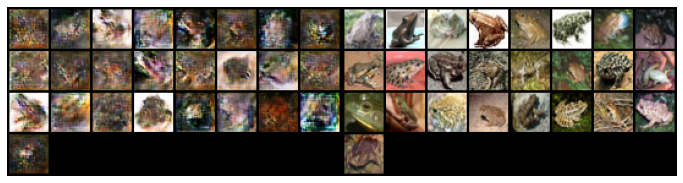

In [110]:
real_image_numpy = np.transpose(torchvision.utils.make_grid(real_image_examples, padding=2, normalize=True, nrow=5),(1,2,0))
fig = plt.figure(figsize=(12,4))
plt.axis("off")
ims = [[plt.imshow(np.hstack((np.transpose(i,(1,2,0)),real_image_numpy)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())